<a href="https://colab.research.google.com/github/scottspurlock/csc4466-2022s/blob/main/tutorials/day19_tutorial_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC 4466 Computer Vision
## Day 19 Tutorial - Pretrained Networks
Adapted from:
- Tensorflow image classification tutorial https://www.tensorflow.org/tutorials/images/classification
- Practical Machine Learning for Computer Vision by Lakshmanan

### Topics
- downloading a pretrained model
- transfer learning
- checkpointing
- early stopping
- saving/restoring models



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Make sure we're using a GPU
If not, go to Colab's Runtime menu, change runtime type, set hardware accelerator to GPU.

In [2]:
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.8.0
Found GPU at: /device:GPU:0


## Download the data

In [3]:
# flowers: 'https://drive.google.com/uc?export=download&id=15Urq38SMTvtkoM55SAAdVlHZ-jANEPA0'

# Download and unzip flowers.zip file.
# Should create 3 folders.
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='15Urq38SMTvtkoM55SAAdVlHZ-jANEPA0',
                                    dest_path='/content/flowers.zip',
                                    unzip=True)

## Set up the data sets to get ready for training

Found 240 files belonging to 3 classes.
Using 192 files for training.
Found 240 files belonging to 3 classes.
Using 48 files for validation.
['bluebell', 'daisy', 'sunflower']


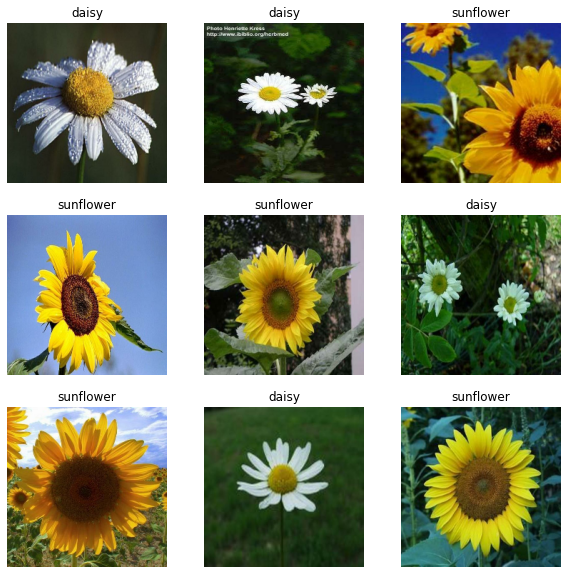

In [4]:
batch_size = 32
img_height = 224
img_width = 224

# This is the folder where our images are
data_dir = 'flowers'

# Tensorflow will choose some of the images as training data
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Tensorflow will chooose the rest of the images as validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# The class names (the names of the different types of images) are
# automatically inferred from the folder names.
class_names = train_ds.class_names
print(class_names)

# The Tensorflow train_ds object makes it easy to get to the images and 
# visualize them
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Transfer learning
## Download a pretrained model
We'll use MobileNetV2, trained on the imagenet data to recognize 1000 different classes, then swap out a different prediction head layer to recognize 3 new classes.

Key points:
- we can download the pretrained model without the last layer (which we don't need since it was designed to predict 1000 imagenet classes) by specifying include_top=False
- we can freeze the pretrained weights in the model by specifying pretrained_model.trainable = False. This is a good idea when we don't have much training data.
- we can tack on our new final layer last to predict the desired classes.


In [5]:
pretrained_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=[img_height, img_width, 3])
pretrained_model.trainable = False # no fine-tuning

model = tf.keras.Sequential([
    # convert image format from int [0,255] to the format expected by this model
    tf.keras.layers.Lambda(lambda data: tf.keras.applications.mobilenet.preprocess_input(tf.cast(data, tf.float32)), input_shape=[img_height, img_width, 3], name='preprocess'),
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(class_names), activation='softmax', name='class_prob')
])

## Model Summary
Notice that the pretrained mobilenet model has 2,257,984 weights already set to good values to recognize images from the imagenet dataset. Since we don't have a lot of training data, we'll leave these alone. They're shown as "non-trainable params" below. We'll just learn 188,163 weights in the final layer. 

In [6]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
    steps_per_execution=8
)
print('Each output from the flattened layer goes to each of the output neurons:', 62720 * 3 + 3)
print()

model.summary()

Each output from the flattened layer goes to each of the output neurons: 188163

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Lambda)         (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 class_prob (Dense)          (None, 3)                 188163    
                                                                 
Total params: 2,446,147
Trainable params: 188,163
Non-trainable params: 2,257,984
_________________________________________________________________


# Checkpointing
For real-world model training, the process usually takes a long time (hours or days). It's a good idea to save "checkpoints" during training in case something happens and the machine crashes or we need to get back to an earlier version of a model.


The easiest way to handle checkpointing is to add a callback function that Tensorflow will call during training.

In [7]:
# Only save a checkpoint if the current validation accuracy is the best so far.
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath='./chkpts',
    monitor='val_sparse_categorical_accuracy', mode='max',
    save_best_only=True)


### Early stopping
It usually makes sense to also have Tensorflow stop training if things aren't improving.

We can specify a patience parameter to set how many epochs to wait for things to improve before quitting.

We set up early stopping as another callback function, and then add it to the list of call backs when fitting the model:
callbacks=[model_checkpoint_cb, early_stopping_cb]



In [8]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_sparse_categorical_accuracy', mode='max',
    patience=2)

epochs = 10

# While training, at the end of each epoch, run the callback functions defined above.
# history = model.fit(train_ds,
#                     validation_data=val_ds,
#                     epochs=epochs,
#                     callbacks=[model_checkpoint_cb, early_stopping_cb])

# To start from the last checkpoint in the chkpts directory:
# model.load_weights(checkpoint_path)

# The downside of checkpoints is that they can take a long time to save.
# For quick tests, it may be better skip the callbacks:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
6/6 [==============================] - 12s 2s/step - loss: 0.6197 - sparse_categorical_accuracy: 0.7760 - val_loss: 2.4678e-05 - val_sparse_categorical_accuracy: 1.0000
Epoch 2/10
6/6 [==============================] - 1s 102ms/step - loss: 0.0293 - sparse_categorical_accuracy: 0.9948 - val_loss: 0.0058 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/10
6/6 [==============================] - 1s 103ms/step - loss: 0.0109 - sparse_categorical_accuracy: 0.9948 - val_loss: 3.5184e-04 - val_sparse_categorical_accuracy: 1.0000
Epoch 4/10
6/6 [==============================] - 1s 102ms/step - loss: 5.3342e-06 - sparse_categorical_accuracy: 1.0000 - val_loss: 4.2036e-05 - val_sparse_categorical_accuracy: 1.0000
Epoch 5/10
6/6 [==============================] - 1s 103ms/step - loss: 9.2318e-07 - sparse_categorical_accuracy: 1.0000 - val_loss: 1.3645e-05 - val_sparse_categorical_accuracy: 1.0000
Epoch 6/10
6/6 [==============================] - 1s 103ms/step - loss: 7.6984e-07 - spa

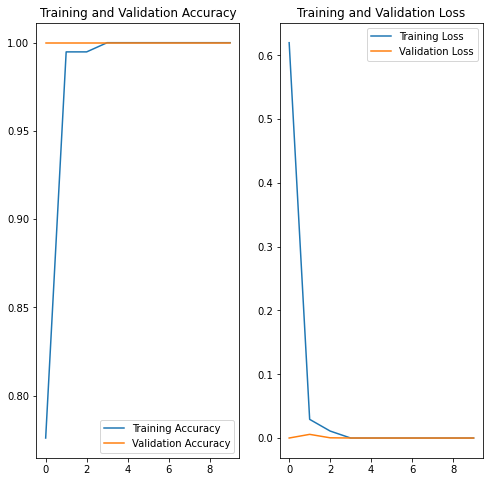

In [9]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Saving / restoring models
Reference: https://learning.oreilly.com/library/view/practical-machine-learning/9781098102357/ch07.html

It's nice to be able to save and later restore a trained model:
- To make inferences from the model
- To resume training

Saving the model for inference is called exporting the model. Saving the model in order to resume training is called checkpointing. Checkpoints are much larger in size than exports because they include a lot more internal state.

In [10]:
# Saving the model for inference
# (This line will error out if the directory already exists)
if not os.path.isdir('export'):
    os.mkdir('export')

model.save('export/flowers_model')

INFO:tensorflow:Assets written to: export/flowers_model/assets


In [11]:
# We can run linux commands to see what's in the folder
!ls export/flowers_model


assets	keras_metadata.pb  saved_model.pb  variables


In [12]:
!saved_model_cli show --tag_set serve --signature_def serving_default --dir export/flowers_model


The given SavedModel SignatureDef contains the following input(s):
  inputs['preprocess_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_preprocess_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['class_prob'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 3)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


## Making predictions

In [13]:
# Helper function to download an image from a url and resize it and reshape it
# so it's ready to be predicted by the model.
def get_image_from_url(url, img_height, img_width):
    !curl -o download.png {url}
    img = cv2.imread('download.png')
    img = cv2.resize(img, (img_width, img_height))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Reshape it so that it is 1 x h x w x 3
    # (The first 1 puts the image in a batch of size 1)
    img_array = np.reshape(img, (1, img_height, img_width, 3))

    return img_array

### Predict 6 newly downloaded images

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1557k  100 1557k    0     0  16.1M      0 --:--:-- --:--:-- --:--:-- 16.3M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5395k  100 5395k    0     0  52.6M      0 --:--:-- --:--:-- --:--:-- 52.6M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.5M  100 18.5M    0     0   125M      0 --:--:-- --:--:-- --:--:--  125M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2910k  100 2910k    0     0  29.9M      0 --:--:-- --:--:-- --:--:-- 29.9M
  % Total    % Received % Xferd  Average Speed   Tim

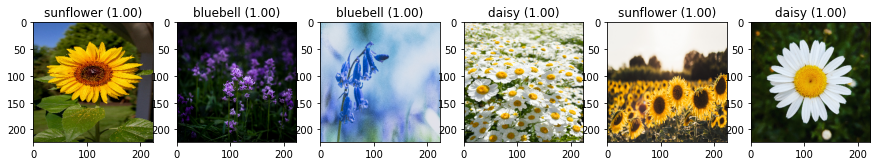

In [14]:
filenames = [
    'https://images.unsplash.com/photo-1566669086984-077347c1f4bb?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=679&q=80',
    'https://images.unsplash.com/photo-1498814628108-a51357de98ca?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=880&q=80',
    'https://images.unsplash.com/photo-1524316607912-93c3468d9d28?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2069&q=80',
    'https://images.unsplash.com/photo-1594417447205-5e1a4e8f05de?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=735&q=80',
    'https://images.unsplash.com/photo-1552160793-cbaf3ebcba72?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1470&q=80',
    'https://images.unsplash.com/photo-1592339078319-1f8cc9d67888?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=880&q=80'
]  
serving_model = tf.keras.models.load_model('export/flowers_model')
input_images = []

for f in filenames:
    input_images.append(get_image_from_url(f, img_height, img_width))

f, ax = plt.subplots(1, 6, figsize=(15,15))
for idx, img in enumerate(input_images):
    ax[idx].imshow(img[0]);

    # Predict the image with the model
    batch_predictions = model.predict(img)

    # There's only one image in the batch
    predictions = batch_predictions[0]

    print('Predictions:')
    print(predictions)

    # Get the index of the max prediction
    pred_label_index = np.argmax(predictions)

    # Get the class label associate with the max index
    pred_label = class_names[pred_label_index]

    # Get the probability associated with the max index
    prob = predictions[pred_label_index]

    # Add a title to the image
    ax[idx].set_title('{} ({:.2f})'.format(pred_label, prob))